# Download Dataset

**Here I will use [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) data set**

In [ ]:
#upload kaggle json
from google.colab import files
files.upload()

In [ ]:
# Make directory named kaggle and copy kaggle.json file there.

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:32<00:00, 82.8MB/s]
100% 2.29G/2.29G [00:32<00:00, 76.8MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

# Explore Data

In [ ]:
import os

In [ ]:
train_path = '/content/chest_xray/chest_xray/train'
test_path = '/content/chest_xray/chest_xray/test'
val_path = '/content/chest_xray/chest_xray/val'


In [ ]:
class_label = ['NORMAL','PNEUMONIA']

**calculte how much data we have**

In [ ]:
num_traning_normal = len(os.listdir(os.path.join(train_path,class_label[0])))
num_training_pneumonia  = len(os.listdir(os.path.join(train_path,class_label[1])))
num_training_images = num_traning_normal + num_training_pneumonia


print("For training we have total {} images in which {} images are noramal and\
 {} images has pneumonia ".format(num_training_images,num_traning_normal\
                                  ,num_training_pneumonia))


num_val_normal = len(os.listdir(os.path.join(val_path,class_label[0])))
num_val_pneumonia  = len(os.listdir(os.path.join(val_path,class_label[1])))
num_val_images = num_val_normal + num_val_pneumonia

print("For validation we have total {} images in which {} images are noramal and\
 {} images has pneumonia ".format(num_val_images,num_val_normal\
                                  ,num_val_pneumonia))


num_test_normal = len(os.listdir(os.path.join(test_path,class_label[0])))
num_test_pneumonia  = len(os.listdir(os.path.join(test_path,class_label[1])))
num_test_images = num_test_normal + num_test_pneumonia

print("For testing we have total {} images in which {} images are noramal and\
 {} images has pneumonia ".format(num_test_images,num_test_normal\
                                  ,num_test_pneumonia))



For training we have total 5218 images in which 1342 images are noramal and 3876 images has pneumonia 
For validation we have total 18 images in which 9 images are noramal and 9 images has pneumonia 
For testing we have total 624 images in which 234 images are noramal and 390 images has pneumonia 


**let plot some images**

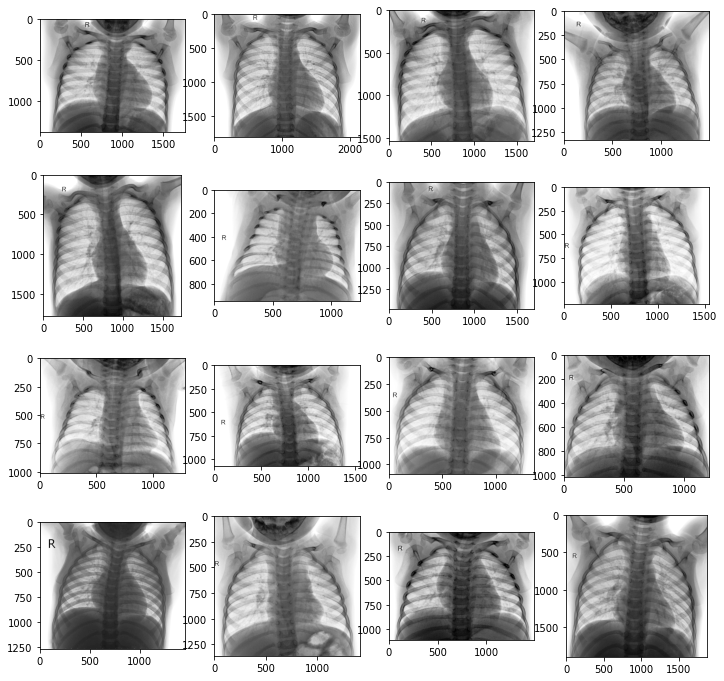

In [ ]:
#https://stackoverflow.com/a/46616645
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from matplotlib.image import 
images_to_plot = []
normal_images =[obj.path for obj in os.scandir(os.path.join(train_path,class_label[0]))]
pneumonia_images =[obj.path for obj in  os.scandir(os.path.join(train_path,class_label[1]))]
images_to_plot = normal_images + pneumonia_images
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = plt.imread(images_to_plot[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='Greys')
plt.show()

# Dealing With Imbalance Dataset

**There are many techniques for deal with imbalance dataset like**


1.   Up sampling
2.   down sampling
3.   class weights



**Here i will use class weights**

In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
image_shape = (224,224)

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_data_gen.flow_from_directory(train_path,target_size=image_shape)
val_generator = val_data_gen.flow_from_directory(val_path,target_size=image_shape)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
weight = class_weight.compute_class_weight(class_weight='balanced',
                      classes=np.unique(train_generator.classes),
                      y = train_generator.classes)

In [ ]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
weight

array([1.9448173 , 0.67303226])

In [ ]:
class_weights = {0:1.9448173,1:0.67303226}

# Transfer Learning Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50,ResNet50V2,MobileNetV2
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
resnet50v2_base = ResNet50V2(include_top=False,weights='imagenet',input_shape=(224,224,3))


94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
resnet50v2_base.trainable = False

In [ ]:
resnet_50v2 = Sequential([
                        resnet50v2_base,
                        Flatten(),
                        Dense(units=512,activation='relu'),
                        Dropout(0.5),
                        Dense(units=512,activation = 'relu'),
                        Dropout(0.2),
                        Dense(2,activation='sigmoid')
])

In [ ]:
resnet_50v2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [ ]:
steps_per_epoch_train = train_generator.samples // train_generator.batch_size


In [ ]:
resnet_50v2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=1,restore_best_weights=True) 

In [ ]:
history = resnet_50v2.fit_generator(train_generator,steps_per_epoch=steps_per_epoch_train,
                          validation_data=val_generator,validation_steps=1,epochs=125
                          ,class_weight=class_weights,callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/125
163/163 [==============================] - 71s 438ms/step - loss: 1.5529 - accuracy: 0.9220 - val_loss: 0.4810 - val_accuracy: 0.8125
Epoch 2/125
163/163 [==============================] - 70s 427ms/step - loss: 0.1270 - accuracy: 0.9674 - val_loss: 0.1531 - val_accuracy: 0.9375
Epoch 3/125
163/163 [==============================] - 69s 426ms/step - loss: 0.1332 - accuracy: 0.9651 - val_loss: 0.0749 - val_accuracy: 1.0000
Epoch 4/125
163/163 [==============================] - 70s 428ms/step - loss: 0.2007 - accuracy: 0.9611 - val_loss: 0.1210 - val_accuracy: 0.9375
Epoch 5/125
163/163 [==============================] - 70s 428ms/step - loss: 0.1522 - accuracy: 0.9688 - val_loss: 0.5827 - val_accuracy: 0.7500
Epoch 6/125
163/163 [==============================] - 69s 423ms/step - loss: 0.1566 - accuracy: 0.9703 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 7/125
163/163 [===========================

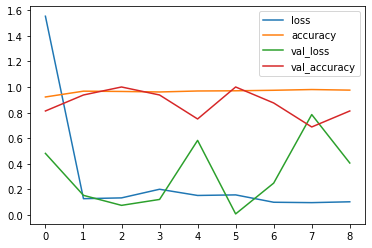

In [ ]:
import pandas as pd
data = pd.DataFrame(history.history)
data.plot()

## Testing

In [ ]:
test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(test_path,target_size=image_shape)

Found 624 images belonging to 2 classes.


In [ ]:
steps = test_generator.samples // test_generator.batch_size

In [ ]:
evaluation = resnet_50v2.evaluate(test_generator,steps=steps,return_dict=True)

19/19 [==============================] - 7s 353ms/step - loss: 0.9406 - accuracy: 0.8503


In [ ]:
evaluation

{'accuracy': 0.8503289222717285, 'loss': 0.9405805468559265}